In [2]:
import sys
sys.path.append('gorani.zip')
sc.addPyFile('gorani.zip')
from gorani import firebase
firebase.init('spark')
mydb = firebase.db()
from gorani.gorani import Gorani
from gorani.transformer import Transformer
from gorani.utils import split_sentence
gorani = Gorani(mydb)
transformer = Transformer(gorani, spark, sc)

In [6]:
df = spark.read.json("clean_logs.json")
df = df.filter(df['scorePerc'] >= 0).filter((F.col('bookId') == 'DZf40OcrwD8C') & (F.col('classId') == '19-grade-6'))

In [7]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
from pyspark.sql.types import *

df2 = df.toPandas()

In [8]:
# df2['z_score'] = df2.groupby('eltime')['eltime'].apply(lambda x: (x - x.mean())/x.std())
df2['z_score'] = (df2['eltime'] - df2['eltime'].mean())/df2['eltime'].std()

In [9]:
import seaborn as sns
df3 = df2.loc[(df2['z_score'] < 1) & (df2['z_score'] > -1)]
sns.jointplot(x=df3['eltime']/1000,y=df3['scorePerc'], kind="kde")

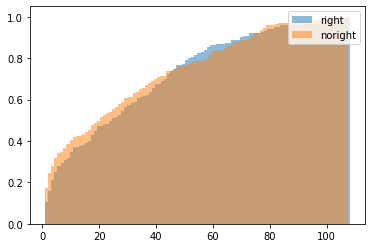

In [10]:
from matplotlib import pyplot as plt
df3 = df2.loc[(df2['z_score'] < 1) & (df2['scorePerc'] > 0.5)]
plt.hist(df3['eltime']/1000, cumulative=True, alpha=0.5, label='right', density=True, bins=100)
df3 = df2.loc[(df2['z_score'] < 1) & (df2['scorePerc'] <= 0.5)]
plt.hist(df3['eltime']/1000, cumulative=True, alpha=0.5, label='noright', density=True, bins=100)
plt.legend(loc='upper right')
plt.show()

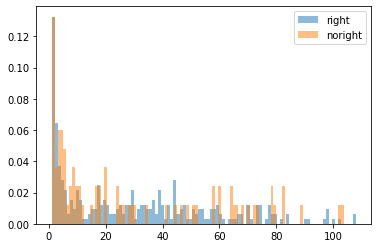

In [11]:
from matplotlib import pyplot as plt
df3 = df2.loc[(df2['z_score'] < 1) & (df2['scorePerc'] >= 0.3)]
plt.hist(df3['eltime']/1000, cumulative=False, alpha=0.5, label='right', density=True, bins=100)
df3 = df2.loc[(df2['z_score'] < 1) & (df2['scorePerc'] < 0.3)]
plt.hist(df3['eltime']/1000, cumulative=False, alpha=0.5, label='noright', density=True, bins=100)
plt.legend(loc='upper right')
plt.show()

In [12]:
senDf = df.withColumn("id", F.monotonically_increasing_id())\
    .withColumn('sentence', F.explode('sentences'))\
    .withColumn('sid', F.col('sentence.sid'))\
    .withColumn('unknown', F.when(F.col('sentence.unknown') == True, 1).otherwise(0))\
    .withColumn('wordCount', F.size('sentence.words'))\
    .withColumn('uwordCount', F.size('sentence.unknownWords'))\
    .groupBy('id', 'userId', 'eltime', 'sentence', 'scorePerc', 'timeZ', 'classId', 'chapterId', 'bookId').agg(F.sum('unknown').alias('usenCount'), 
                       F.sum('wordCount').alias('wordCount'), 
                       F.sum('uwordCount').alias('uwordCount'))\
    .drop('id').withColumn('wpm', F.col('wordCount')/(F.col('eltime')/(1000*60))).filter(F.col('wpm') < 1000)



In [39]:
c = 0
@F.udf(IntegerType())
def readingScore(ac, wpm):
    if ac > 0.7 and wpm > 200 + c:
        return 12
    elif ac > 0.65 and wpm > 190 + c:
        return 11
    elif ac > 0.6 and wpm > 180 + c:
        return 10
    elif ac > 0.55 and wpm > 170 + c: 
        return 9
    elif ac > 0.5 and wpm > 160 + c:
        return 8
    elif ac > 0.45 and wpm > 150 + c:
        return 7
    elif ac > 0.4 and wpm > 140 + c:
        return 6
    elif ac > 0.35 and wpm > 120 + c:
        return 5
    elif ac > 0.3 and wpm > 100 + c:
        return 4
    elif ac > 0.25 and wpm > 80 + c:
        return 3
    elif ac > 0.2 and wpm > 60 + c:
        return 2
    else:
        return 1

In [40]:
userDf = senDf.groupBy('classId','bookId','userId')\
    .agg(F.count('*').alias('count'), F.avg('wpm').alias('wpm'), F.avg('scorePerc').alias('scorePerc'), F.sum('uwordCount').alias('uwordCount'))\
    .withColumn('rc', readingScore('scorePerc','wpm'))\
    .withColumn('username', transformer.get_username('userId'))


In [41]:
df2 = userDf.toPandas()

In [42]:
df2

,classId,bookId,userId,count,wpm,scorePerc,uwordCount,rc,username
0,19-grade-6,DZf40OcrwD8C,3dkoVNdFAoch4sxXEtWo,220,34.388856,0.622186,4,1,Youngwon Jung
1,19-grade-6,DZf40OcrwD8C,ZYTj0ZyUTpLsaxb0zoSB,118,94.885449,0.418180,52,3,Geonwoo Yi
2,19-grade-6,DZf40OcrwD8C,VbFRYXiXVyBLWzGDlqqm,254,112.850602,0.530231,22,4,Yoonho Jung
3,19-grade-6,DZf40OcrwD8C,CvfwJERcCjcXtzFo8Xfe,84,253.749247,0.095238,3,1,Seyeon Kim
4,19-grade-6,DZf40OcrwD8C,7ksTSrU6NjGGoZqnu7uG,145,194.704656,0.239409,64,2,Jungeun Pyun
5,19-grade-6,DZf40OcrwD8C,bmKnPQcO48sDdLAKy5Lu,189,110.910458,0.772739,131,4,Ain Lee
6,19-grade-6,DZf40OcrwD8C,xP0QeRM7qCAi1bOSAt1o,223,115.825247,0.550075,65,4,Hanjun Lee
7,19-grade-6,DZf40OcrwD8C,0bHdAlU0BUXj4OLRPzTZ,183,57.522413,0.425449,12,1,Yoseop Jeong
8,19-grade-6,DZf40OcrwD8C,qtW5EhH8cUORCIwwOSiX,204,26.474197,0.251459,115,1,Yeonwoo Na
9,19-grade-6,DZf40OcrwD8C,AWJ3AzY0AdAUKDqerSwH,89,175.234360,0.333333,14,4,Seojin Moon


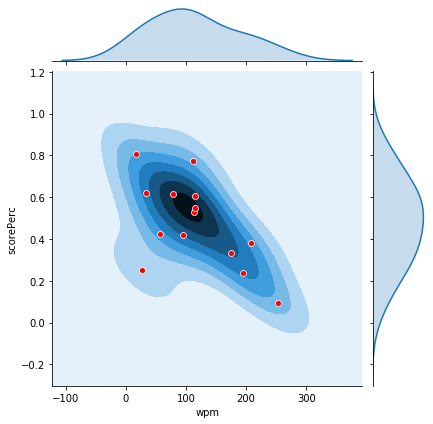

In [22]:
sns.jointplot(x=df2['wpm'],y=df2['scorePerc'], kind='kde').plot_joint(sns.scatterplot, color='r')


In [35]:
# df2['z_score'] = df2.groupby('eltime')['eltime'].apply(lambda x: (x - x.mean())/x.std())
df2 = senDf.toPandas()
df2['z_score'] = (df2['wpm'] - df2['wpm'].mean())/df2['wpm'].std()

In [36]:
df2['more'] = df2.apply(lambda row: row['wpm'] > 900, axis=1)

df2.more.value_counts(True)

False    0.993673
True     0.006327
Name: more, dtype: float64

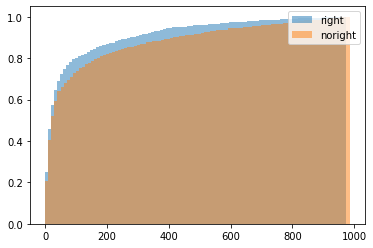

In [37]:
from matplotlib import pyplot as plt
df3 = df2.loc[(df2['scorePerc'] > 0.5)]
plt.hist(df3['wpm'], cumulative=True, alpha=0.5, label='right', density=True, bins=100)
df3 = df2.loc[(df2['scorePerc'] <= 0.5)]
plt.hist(df3['wpm'], cumulative=True, alpha=0.5, label='noright', density=True, bins=100)
plt.legend(loc='upper right')
plt.show()

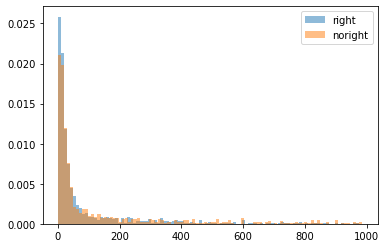

In [38]:
from matplotlib import pyplot as plt
df3 = df2.loc[(df2['scorePerc'] > 0.5)]
plt.hist(df3['wpm'], cumulative=False, alpha=0.5, label='right', density=True, bins=100)
df3 = df2.loc[(df2['scorePerc'] <= 0.5)]
plt.hist(df3['wpm'], cumulative=False, alpha=0.5, label='noright', density=True, bins=100)
plt.legend(loc='upper right')
plt.show()

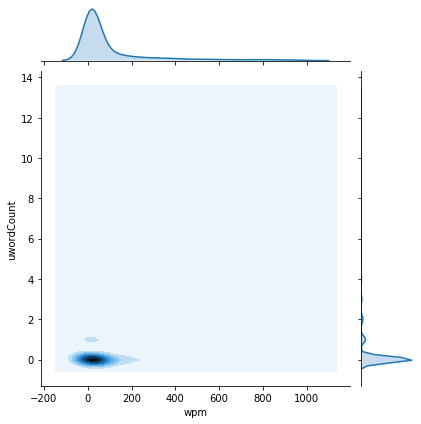

In [84]:
sns.jointplot(x=df2['wpm'],y=df2['uwordCount'], kind='kde')

In [45]:
@F.pandas_udf(IntegerType())
def uscore(x,y):
    import pandas as pd
    return pd.Series([1 if y in x else 0 for x, y in zip(x,y)])

In [50]:
vcDf = senDf.withColumn("id", F.monotonically_increasing_id())\
    .withColumn('sid', F.col('sentence.sid'))\
    .withColumn('wordCount', F.size('sentence.words'))\
    .withColumn('word', F.explode('sentence.words'))\
    .withColumn('no', uscore('sentence.unknownWords', F.col('word')))\
    .withColumn('yes', 1 - F.col('no'))\
    .withColumn('word', F.lower(F.col('word')))\
    .dropDuplicates(['id','sid','word'])\
    .groupBy('id', 'userId', 'bookId')\
    .agg(F.sum('yes').alias('nwordCount'),F.sum('no').alias('uwordCount'))\
    .groupBy('userId', 'bookId').agg(F.sum('nwordCount').alias('nwordCount'), F.sum('uwordCount').alias('uwordCount'))\
    .withColumn('uperc', F.col('uwordCount') / (F.col('uwordCount') + F.col('nwordCount')))
vcDf.show()

+--------------------+------------+----------+----------+--------------------+
|              userId|      bookId|nwordCount|uwordCount|               uperc|
+--------------------+------------+----------+----------+--------------------+
|ZYTj0ZyUTpLsaxb0zoSB|DZf40OcrwD8C|      1475|        44|0.028966425279789335|
|bmKnPQcO48sDdLAKy5Lu|DZf40OcrwD8C|      2063|       115|0.052800734618916434|
|7ksTSrU6NjGGoZqnu7uG|DZf40OcrwD8C|      1559|        57| 0.03527227722772277|
|qtW5EhH8cUORCIwwOSiX|DZf40OcrwD8C|      2337|       112|0.045732952225398124|
|VbFRYXiXVyBLWzGDlqqm|DZf40OcrwD8C|      3012|        14|0.004626569729015202|
|1yz9QcMjyGFMMdC6LPlJ|DZf40OcrwD8C|      2341|         8|0.003405704555129...|
|xP0QeRM7qCAi1bOSAt1o|DZf40OcrwD8C|      2447|        59|0.023543495610534718|
|3dkoVNdFAoch4sxXEtWo|DZf40OcrwD8C|      2574|         4|0.001551590380139...|
|g11JTV6am9fleET7bIid|DZf40OcrwD8C|      2583|         0|                 0.0|
|AWJ3AzY0AdAUKDqerSwH|DZf40OcrwD8C|      1050|      